# Generating Clash Royale Decks
[Clash Royale](https://clashroyale.com/) is a popular mobile game created by Supercell. Players create decks consisting of 8 unique cards from a collection of over 100 - making billions of possible decks. Creating new decks to fit a particular meta either takes a lot of knowlege, so we can use a model to understand what combinations work well together. This notebook aims to use a neural net to generate Clash Royale decks.

In [1]:
# Imports
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
!pip install albumentations --upgrade
import albumentations
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from IPython.display import clear_output

from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/gdrive", force_remount=True)

import sys
sys.path.append('/content/gdrive/MyDrive/PyTorch/')
from MiniTorch.minitorch import colab_utils
colab_utils.copy_minitorch_to_local()
sys.path.append("/content/")
import datasets
from minitorch import MiniTorch
%load_ext autoreload
%autoreload 2

clear_output()

# Prepare Data
We start with 100k "grand challenge" decks. These are usually decks from the highest quality matches in the game since players need to spend a considerable amount of in-game currency (gems) to enter. To process this data for modeling, I chose to use one of the 8 cards as the target and the remaining 7 cards as the input (self-supervised learning). Because there's so much duplication among the top decks players use I iterate over each deck to take each of the cards out as targets, which results in at most 8 unique records per deck. Further, I ensure that each input/target combination is unique.

In [2]:
# Read in 100k GC decks data
df = pd.read_csv('/content/gdrive/My Drive/PyTorch/MiniTorch/data/gc-data-2020.04-100000.csv')
for i in range(1,9):
    df['card'+str(i)] = df['card'+str(i)].apply(lambda x: x.replace('-', ' ').title().replace('Pekka', 'P.E.K.K.A').replace('X Bow', 'X-Bow'))
decks = np.array([d for d in df.values[:,1:] if 'Heal' not in d])

# Create card look up dictionary
all_cards = set(decks.flatten())
card2ind = pickle.loads(open('/content/gdrive/My Drive/PyTorch/MiniTorch/data/2020_09_06_card2ind.p', 'rb').read())
ind2card = {v:k for k,v in card2ind.items()}

# Helper function
def one_hot_encode(deck):
  ohe_deck = np.zeros(len(card2ind))
  for card in deck:
    ohe_deck[card2ind[card]] = 1
  return ohe_deck

In [3]:
# Create dataset: For each deck, remove each of the cards
used_decks = []
seven_card_decks_str, seven_card_decks_ohe = [], []
target_cards_str, target_cards_ohe = [], []
for deck in tqdm(decks):
  for i in range(len(deck)):
    deck = list(deck)
    removed_card = deck[i]
    if str(sorted(deck)+[removed_card]) not in used_decks:
      used_decks.append(str(sorted(deck)+[removed_card]))
    else:
      continue
    deck_ = [d for d in deck if d != removed_card]
    seven_card_decks_str.append(deck_)
    seven_card_decks_ohe.append(one_hot_encode(deck_))
    target_cards_str.append(removed_card)
    target_cards_ohe.append(one_hot_encode([removed_card]))
  
seven_card_decks_str = np.array(seven_card_decks_str)
seven_card_decks_ohe = np.array(seven_card_decks_ohe)
target_cards_str = np.array(target_cards_str)
target_cards_ohe = np.array(target_cards_ohe)

seven_card_decks_ohe.shape, target_cards_ohe.shape

100%|██████████| 100000/100000 [02:30<00:00, 665.93it/s]


((123040, 98), (123040, 98))

# Load Data

In [4]:
# Instantiate MiniTorch and load data
minitorch = MiniTorch(seven_card_decks_ohe, target_cards_str, 
                      datasets.MatrixDataset,
                      transforms=None,
                      val_size=0.10, test_size=0.10,
                      batch_sizes=(32,-1,-1), num_workers=(0,0,0))

Data is split:
Training shape: ((98432, 98), (98432, 98))
Validation shape: ((12304, 98), (12304, 98))
Testing shape: ((12304, 98), (12304, 98))

Data is loaded into DataLoaders.


# Train New Model
I used a few different models and settled on this one. It's rather simple with only linear layers and ReLu activations, and even has enough power to overfit the training data. I also experimented with Random Forests, but they tended to overfit much more.

In [5]:
# Define model
class LinearNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(
      nn.Linear(98, 98*3),
      nn.ReLU(inplace=True),
      nn.Linear(98*3, 98*2),
      nn.ReLU(inplace=True),
      nn.Linear(98*2, 98*1)
    )

  def forward(self, x):
    x = x.view(-1, 98*1)
    x = self.classifier(x)
    return x

In [6]:
# Load model
minitorch.load_net(net=LinearNet(), weights='equal',
                   chosen_criterion=nn.CrossEntropyLoss, 
                   chosen_optimizer=optim.Adam,
                   chosen_optimizer_params={'lr':0.001, 'betas':(0.9, 0.999), 'eps':1e-08, 'weight_decay':0, 'amsgrad':False})


Network is loaded.



[1,   500] train_loss: 4.026 | val_loss: 3.654
[1,  1000] train_loss: 3.447 | val_loss: 3.240
[1,  1500] train_loss: 3.191 | val_loss: 3.108
[1,  2000] train_loss: 3.103 | val_loss: 3.039
[1,  2500] train_loss: 3.027 | val_loss: 2.979
[1,  3000] train_loss: 2.955 | val_loss: 2.943
[2,   500] train_loss: 3.318 | val_loss: 2.902
[2,  1000] train_loss: 2.880 | val_loss: 2.880
[2,  1500] train_loss: 2.841 | val_loss: 2.856
[2,  2000] train_loss: 2.805 | val_loss: 2.842
[2,  2500] train_loss: 2.796 | val_loss: 2.821
[2,  3000] train_loss: 2.808 | val_loss: 2.809
[3,   500] train_loss: 3.114 | val_loss: 2.805
[3,  1000] train_loss: 2.683 | val_loss: 2.795
[3,  1500] train_loss: 2.700 | val_loss: 2.776
[3,  2000] train_loss: 2.689 | val_loss: 2.757
[3,  2500] train_loss: 2.693 | val_loss: 2.748
[3,  3000] train_loss: 2.673 | val_loss: 2.753
[4,   500] train_loss: 2.993 | val_loss: 2.747
[4,  1000] train_loss: 2.583 | val_loss: 2.734
[4,  1500] train_loss: 2.589 | val_loss: 2.724
[4,  2000] tr

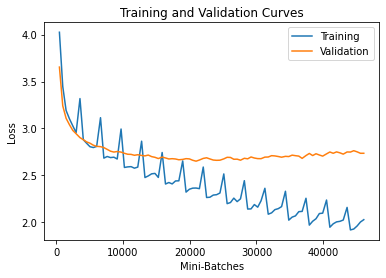

Finished Training


In [7]:
# Train model
minitorch.train(epochs=15, log_mini_batches=500)

# Load Trained Model (optional)

Loaded epoch8_model.pt in eval mode.



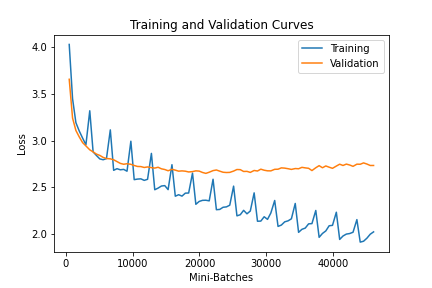

In [8]:
# Load trained model (optional to showcase loading from saved state. Requires model to be defined in current session.)
# Since the model was overfitting a bit at 15 epochs, we'll use the model at 8 epochs (around 24k mini-batches)
minitorch = MiniTorch.load_checkpoint(net=LinearNet(), 
                                      checkpoints_path='/content/model_checkpoints/20210123T212042_models/',
                                      model_name='epoch8_model.pt', load_type='eval')

# Evaluate
We can expect this model to be \~35% accurate on unseen deck combinations, which is incredibly good compared to a random model picking from \~100 possible cards (~1% accuracy). Further, we can see how the cards rank when trying to predict them with a hit@n metric. The model does well trying to predict cards that are used often in the training set like Zap and Mini P.E.K.K.A and worse on those which are not like Royal Recruits and Fisherman. This should create recommendations for cards that players tend to use more often.

Evaluating Train set...
100%|██████████| 3076/3076 [00:15<00:00, 204.83it/s]
Train Accuracy: 44.58%
Train Hit@N: 4.93577

Evaluating Validation set...
100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
Validation Accuracy: 34.41%
Validation Hit@N: 8.24967

Evaluating Test set...
100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
Test Accuracy: 34.33%
Test Hit@N: 8.30388



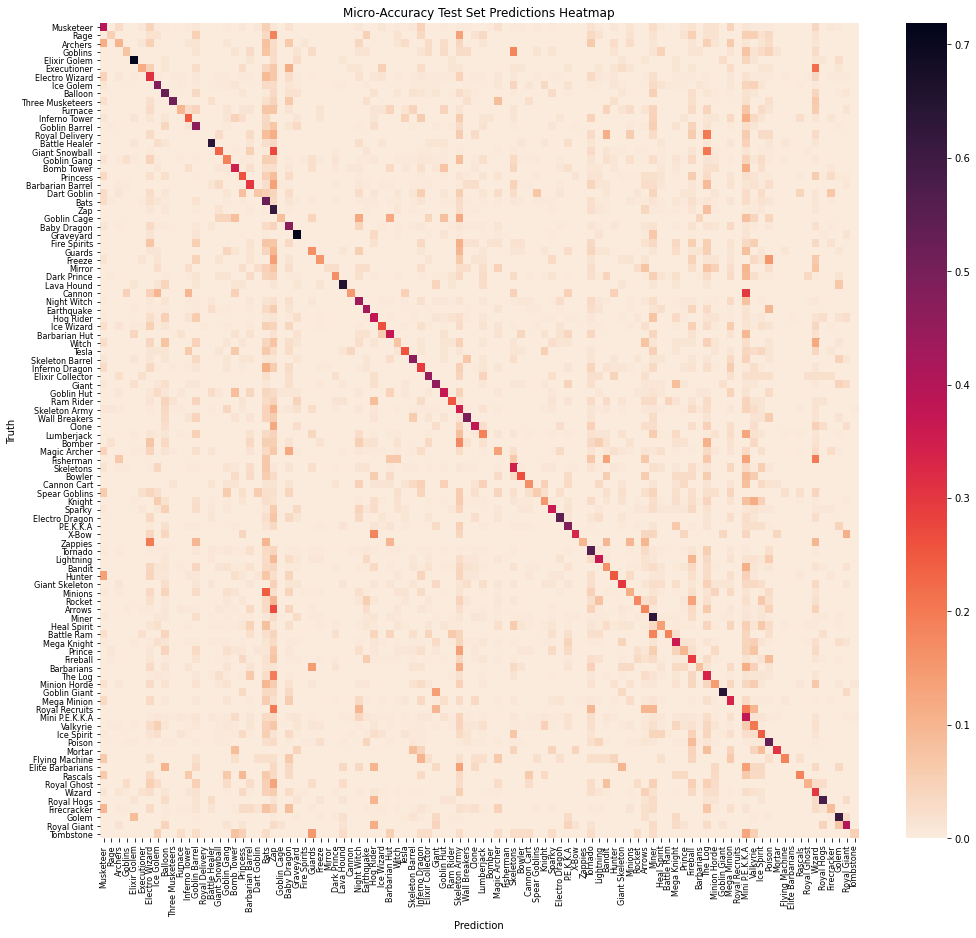

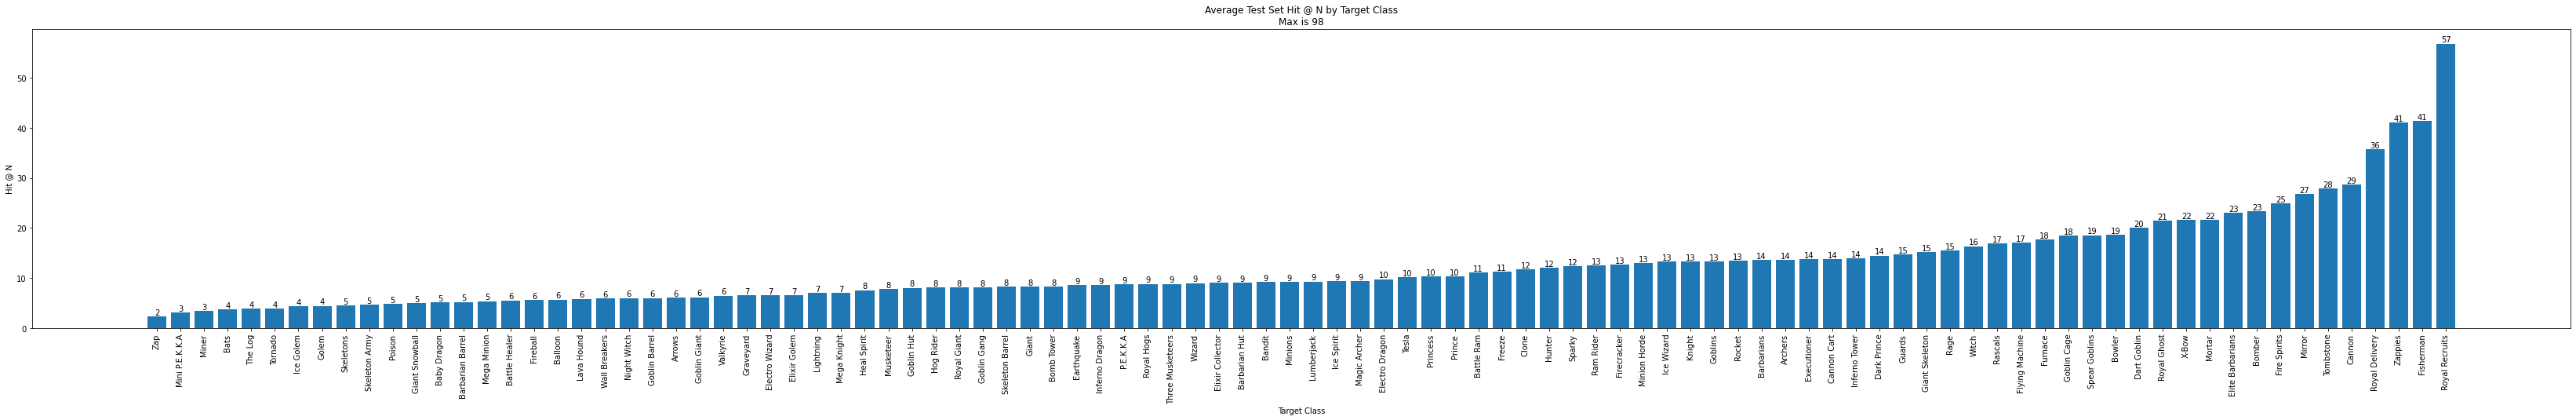

In [9]:
# Evaluate model
minitorch.evaluate(evaluation_metrics=['accuracy', 'hit@n'], 
                   kwargs={
                       'accuracy': {'annot':False}
                   })

# Use Model to Build Decks
This is where things get interesting! I use three methods to test how the model has understood how to build a good deck.
>1. Take any number of input cards (between 1 and 7) and use beam search to create the most likely decks from those inputs. Using this approach I generated decks for Miner and found some new, interesting decks! Useful for generating a handful of decks quickly.
>2. Take any number of input cards (between 1 and 7) and see what the top n recommendations are for the next card in the deck. This method allows us to see what beam search sees at any given point in the generation process. Useful for getting an idea for another card to include in a deck.
>3. Use method #2 in an iterative fashion with feedback from the player. In this way a player can generate their own deck with help from the model. Useful for players who want more control over making a deck.

In [10]:
# Get original training decks for testing novelty of decks created
train_decks = np.vstack([np.hstack([x.squeeze(1).squeeze(1).cpu().numpy(), y.cpu().numpy()]) \
                          for x,y in minitorch.trainloader]).tolist()

In [11]:
# Iteratively create a deck given inputs (beam search)
# (https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)

from operator import itemgetter
from copy import deepcopy
from collections import Counter

k = 3
input_decks = [[['Miner'], 1]]

for i in range(8-len(input_decks[0][0])):
  replace_input_decks = []
  used_decks = []
  for deck in input_decks:
    ohe_deck = one_hot_encode(deck[0])
    probs = minitorch.predict(ohe_deck, softmax=True)
    preds = np.argsort(probs)[::-1]
    count = 0
    for p in preds:
      new_deck = deepcopy(deck)
      pred_card = minitorch.ind2target[p]
      pred_prob = probs[p]
      if pred_card not in deck[0]:
        new_deck[0].extend([pred_card])
        if sorted(new_deck[0]) not in used_decks:
          count += 1
          used_decks.append(sorted(new_deck[0]))
          new_deck[1] = new_deck[1]*pred_prob
          replace_input_decks.append(new_deck)
          if count == k:
            break
  input_decks = replace_input_decks
        
print(len(input_decks))
for deck_ in sorted(input_decks, key=itemgetter(1), reverse=True)[:10]:
  print(deck_)
  print(Counter([True if sorted(deck_[0])==sorted(d) else False for d in train_decks])) # This makes it very slow
  print()

2187
[['Miner', 'The Log', 'Mega Minion', 'Poison', 'Goblin Hut', 'Electro Wizard', 'P.E.K.K.A', 'Goblins'], 1.0055891513279637e-05]
Counter({False: 98432})

[['Miner', 'The Log', 'Mega Minion', 'Poison', 'Mini P.E.K.K.A', 'Electro Wizard', 'Giant', 'Zap'], 7.648646295219873e-06]
Counter({False: 98432})

[['Miner', 'The Log', 'Poison', 'Hunter', 'Skeletons', 'Ice Golem', 'Ice Spirit', 'Bats'], 6.688954397785226e-06]
Counter({False: 98432})

[['Miner', 'The Log', 'Bats', 'Mini P.E.K.K.A', 'Skeletons', 'Magic Archer', 'Wall Breakers', 'Ice Golem'], 5.939231568898562e-06]
Counter({False: 98432})

[['Miner', 'The Log', 'Mega Minion', 'Poison', 'Goblin Hut', 'Electro Wizard', 'Mini P.E.K.K.A', 'Giant'], 5.19454163826113e-06]
Counter({False: 98432})

[['Miner', 'Wall Breakers', 'Bats', 'Giant Snowball', 'Mini P.E.K.K.A', 'Firecracker', 'Ice Golem', 'Skeletons'], 4.927134905221477e-06]
Counter({False: 98432})

[['Miner', 'Zap', 'Minion Horde', 'Goblin Gang', 'Mortar', 'Bats', 'Cannon Cart', '

In [12]:
# Check predictions given inputs
input_deck = ['Miner']
ohe_deck = one_hot_encode(input_deck)

outputs = minitorch.predict(ohe_deck)
preds = np.argsort(outputs[0])[::-1][:5]

print('Find cards for: {}'.format(input_deck))
print('Predictions: {}'.format(', '.join([minitorch.ind2target[p] for p in preds])))

Find cards for: ['Miner']
Predictions: Zap, The Log, Wall Breakers, Goblin Gang, Baby Dragon


In [13]:
# Make a deck one card at a time based on user input

from IPython.display import HTML

card_images_dict = pickle.loads(open('/content/gdrive/My Drive/PyTorch/MiniTorch/data/2020_11_07_card_images_dict.p', 'rb').read())
def show_deck(deck):
  html_decks = ''.join([f"""<img src="{card_images_dict[card]}" style="height:100px;"/>""" for card in deck])
  display(HTML(f"""<table><tr><td>{html_decks}</td></tr></table>"""))

input_cards_str = input("What cards are you starting with? ")
input_deck = [d.strip() for d in input_cards_str.split(',')]
for card in input_deck:
  if card_images_dict.get(card) is None:
    raise ValueError(f"{card} is not an acceptable input. Try again.")
print('Your deck:')
show_deck(input_deck)
while len(input_deck) < 8:
  ohe_deck = one_hot_encode(input_deck)
  outputs = minitorch.predict(ohe_deck)
  preds = np.argsort(outputs[0])[::-1]
  available_cards = [minitorch.ind2target[p] for p in preds if minitorch.ind2target[p] not in input_decks][:10]
  print('Top 10 suggested cards:')
  show_deck(available_cards)
  added_card = input("Which card do you want to add? ")
  if card_images_dict.get(added_card) is None:
    raise ValueError(f"{added_card} is not an acceptable input. Try again.")
  input_deck.append(added_card)
  print('Your deck:')
  show_deck(input_deck)
  print('*'*50)

What cards are you starting with? Miner
Your deck:


""


Top 10 suggested cards:


""


Which card do you want to add? Wall Breakers
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? The Log
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Firecracker
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Bomb Tower
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Bats
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Knight
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Skeletons
Your deck:


""


**************************************************
